In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from dateutil.relativedelta import relativedelta
import xarray as xr

In [2]:
base_path = Path("/Users/frasergoldsworth/Projects/irminger-proj")

In [3]:
interim_path = base_path / "data/interim"

In [4]:
era5_path = interim_path / "ERA5_hourly_SI_ilebras.nc"

In [5]:
ds = xr.open_dataset(era5_path)
ds["tau"]

<xarray.DataArray 'tau' (time: 43824, longitude: 9)>
[394416 values with dtype=float32]
Coordinates:
    latitude   float32 ...
  * longitude  (longitude) float32 -43.0 -42.75 -42.5 ... -41.5 -41.25 -41.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00

In [6]:
sel_months = [11, 12, 1, 2, 3, 4]
sel_months=[5, 6, 7, 8, 9, 10]
ds_winter = ds.where((ds["time"].dt.month >= 11) | (ds["time"].dt.month <= 4), drop=True)
ds_winter["time"] = (ds_winter["time"] + np.timedelta64(61, "D"))
ds_winter = ds_winter.mean("longitude")
ds_winter = ds_winter.where((ds["time"].dt.year >= 2015) & (ds["time"].dt.year <= 2018), drop=True)

In [7]:
upper_limits = np.linspace(0, -3, 50)
tau_int = []
for upper_limit in upper_limits:
    ds_down_front = ds_winter.where(ds_winter["tau"] <= 0.0, drop=True)
    ds_down_front = ds_down_front.where((ds_down_front["tau"] <= 0.0) & (ds_down_front["tau"] >= upper_limit), upper_limit)
    tau_int += [((ds_down_front["tau"] / 24 ).sum("time") / 4).values]
#ds_down_front["tau"].plot()
tau_int = np.stack(tau_int)

In [8]:
fpath = Path('/System/Library/Fonts/Supplemental/Arial.ttf')
if fpath.exists():
    font_prop = fm.FontProperties(fname=fpath)
    plt.rcParams['font.family'] = font_prop.get_family()
    plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

# font size
plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rc('text', usetex=False)
plt.rcParams['axes.titlesize'] = 10
plt.rc('text', usetex=False)

/var/folders/ds/b3ml_q7x26l8_6yp8_lv80h00000gn/T/ipykernel_1976/2255876411.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


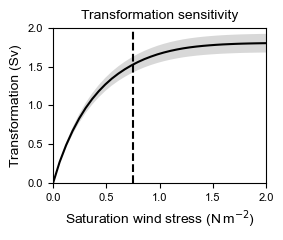

In [21]:
fig = plt.figure(figsize=(3, 2.5))
ax = plt.gca()
ax.plot(-upper_limits, -tau_int * 3e-4 * 200, c="k")
ax.fill_between(-upper_limits,
                 -tau_int * 3.2e-4 * 200,
                 -tau_int * 2.8e-4 * 200,
                 alpha=0.3, color="grey", edgecolor=None)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)

ax.set_xlabel("Saturation wind stress (N$\,$m$^{-2}$)")
ax.set_ylabel("Transformation (Sv)")
ax.axvline(0.75, c="k", ls="--")

ax.set_title("Transformation sensitivity")

fig.tight_layout()

fig.savefig(base_path / "reports/TransformationSensitivity.pdf", transparent=True)
fig.show()

In [17]:
-tau_int[12] * 3e-4 * 200

1.514889450073242

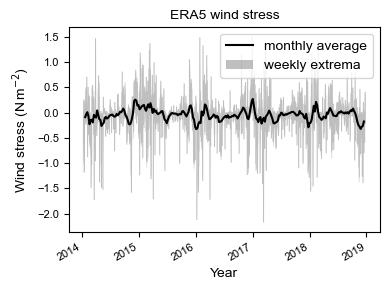

In [19]:
plt.close()
da_tau_lonmn = ds["tau"].mean("longitude")


plt.figure(figsize=(4, 3))

da_tau_lonmn.rolling({"time": 24 * 31}, center=True).mean().resample({"time": "1W"}).nearest().plot(
    c="black",
    label="monthly average"
)

plt.fill_between(
    da_tau_lonmn["time"],
    da_tau_lonmn.rolling({"time": 24 * 7}, center=True).reduce(np.quantile, q=0.95),
    da_tau_lonmn.rolling({"time": 24 * 7}, center=True).reduce(np.quantile, q=0.05),
    alpha=0.5,
    color="grey",
    edgecolor=None,
    label="weekly extrema"
)

plt.title("ERA5 wind stress")
plt.xlabel("Year")
plt.ylabel("Wind stress (N$\,$m$^{-2}$)")
plt.legend()
plt.tight_layout()
plt.show()